0.693195930467
-2
0.399143355263
-2


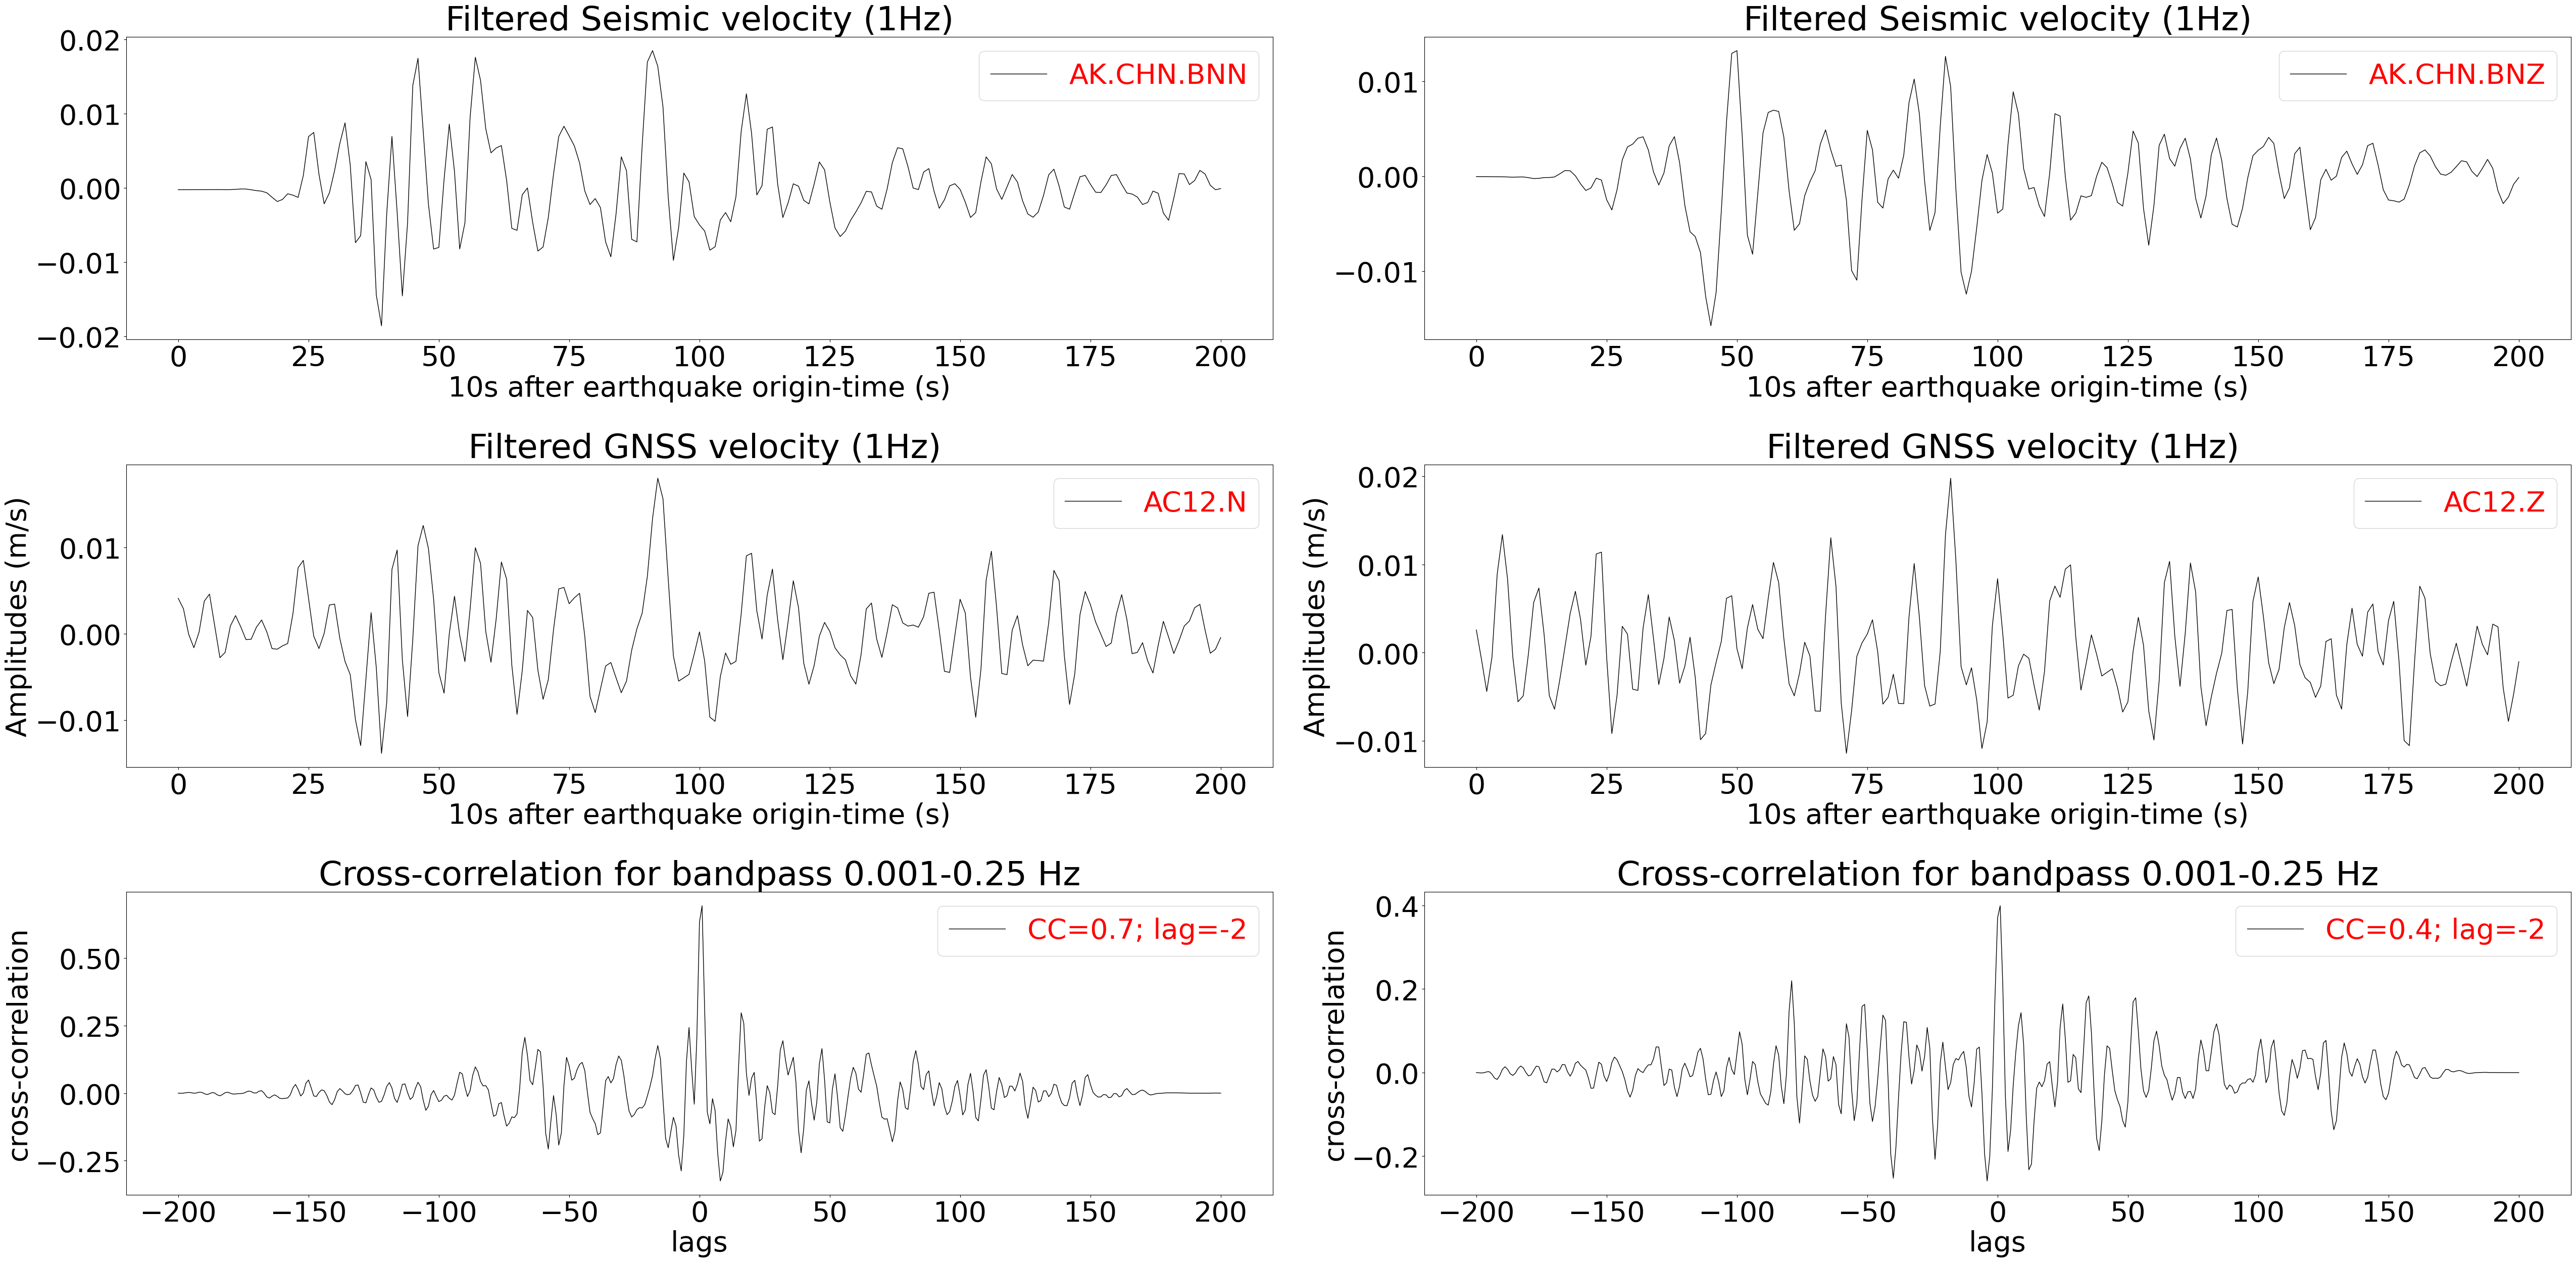

In [6]:
######## GNSS instavel Vs strong-motion derived velocity analysis and plots ##################
################################## Scipy version #############################################
####################################### Goals ################################################
#     1) Read a GNSS instavel and convert it into an obspy stream
#     2) Filter instavel
#     3) Load acceleration from IRIS client
#     4) Filter and integrate strong-motion acceleration to corresponding velocity
#     5) Subtract/find difference between GNSS and strong motion veocity
#     6) Subtract the difference from GNSS and plot trace
#     7) cross-correlate and plot both versions
##############################################################################################

from obspy import UTCDateTime 				
from obspy import Trace
from obspy import Stream
from obspy import read_inventory
from obspy.signal.cross_correlation import correlate
from obspy.clients.fdsn import Client 		
client=Client("IRIS")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.cm as cmx
import datetime

def compute_shiftn(ccn):
    zero_index = int(len(ccn) / 2) - 1
    shift = zero_index - np.argmax(ccn)
    return shift

def compute_shiftz(ccz):
    zero_index = int(len(ccz) / 2) - 1
    shift = zero_index - np.argmax(ccz)
    return shift

# READ INSTAVEL ASCII FILE
infile = 'Chignik_phase_vels/ac12_1hz.L2.igr.phase_vels'
site = np.genfromtxt(infile, dtype=None, encoding=None, names=['date','time','dt','lat','lon','height','vx', 'vy', 'vz', 'sigx', 'sigy', 'sigz', 'vdt', 'vn', 've', 'vu', 'sign', 'sige', 'sigu'])

# CREATE AN EMPTY STREAM AND POPULATE WITH NORTH INSTAVEL DATA
st_gnss_vn = Stream(Trace())
st_gnss_vn[0].stats.network = '--'
st_gnss_vn[0].stats.station = 'AC12'
st_gnss_vn[0].stats.channel = 'IVN'       # for [I]nst[V]el [E] component]
st_gnss_vn[0].stats.starttime = site["date"][0] + 'T' + site["time"][0]
st_gnss_vn[0].stats.sampling_rate = 1
st_gnss_vn[0].stats.calib = 1
st_gnss_vn[0].data = site['vn']
st_gnss_vn[0].detrend('linear')
st_gnss_vn[0].detrend('demean')
dt = UTCDateTime("2021-07-29T06:15:47.000000Z")
st_gnss_vn[0].trim(dt+10, dt+210)

st_gnss_fn = st_gnss_vn[0].copy()
st_gnss_fn.filter('bandpass', freqmin=0.001, freqmax=0.25, corners=4, zerophase=True)


# CREATE AN EMPTY STREAM AND POPULATE WITH VERTICAL INSTAVEL DATA
st_gnss_vz = Stream(Trace())
st_gnss_vz[0].stats.network = '--'
st_gnss_vz[0].stats.station = 'AC12'
st_gnss_vz[0].stats.channel = 'IVZ'       # for [I]nst[V]el [E] component]
st_gnss_vz[0].stats.starttime = site["date"][0] + 'T' + site["time"][0]
st_gnss_vz[0].stats.sampling_rate = 1
st_gnss_vz[0].stats.calib = 1
st_gnss_vz[0].data = site['vz']
st_gnss_vz[0].detrend('linear')
st_gnss_vz[0].detrend('demean')
dt = UTCDateTime("2021-07-29T06:15:47.000000Z")
st_gnss_vz[0].trim(dt+10, dt+210)

st_gnss_fz = st_gnss_vz[0].copy()
st_gnss_fz.filter('bandpass', freqmin=0.001, freqmax=0.25, corners=4, zerophase=True)


# LOAD N SEISMIC ACCELERATION STREAM FROM IRIS DMC
start = UTCDateTime("2021-07-29T06:15:57.008400Z")
st_seis_an = client.get_waveforms('AK', 'CHN', "*", 'BNN', (start), (start+200), attach_response=True)

# TIDY UP ACCELERATION TRACE
st_seis_an[0].remove_response(inventory=None, output="ACC", plot=False)
st_seis_an[0].detrend('linear')
st_seis_an[0].detrend('demean')

# CREATE A SEISMIC VELOCITY TRACE
st_seis_vn = st_seis_an[0].copy()
st_seis_vn.integrate(method='cumtrapz')
hzn = st_seis_vn.data[::50]   # Brute-force 'downsampling' of strong-motion derived velocity to 1 Hz post-filtering and -integration

# CREATE AN EMPTY STREAM AND POPULATE WITH 1Hz N STRONG-MOTION DERIVED VELOCITY DATA
st_sm_vn = Stream(Trace())
st_sm_vn[0].stats.network = 'AK'
st_sm_vn[0].stats.station = 'CHN'
st_sm_vn[0].stats.channel = 'BNN'    
st_sm_vn[0].stats.starttime = UTCDateTime("2021-07-29T06:15:57.0Z")
st_sm_vn[0].stats.sampling_rate = 1
st_sm_vn[0].stats.calib = 1
st_sm_vn[0].data = hzn

st_sm_fn = st_sm_vn[0].copy()
st_sm_fn.filter('bandpass', freqmin=0.001, freqmax=0.25, corners=4, zerophase=True)

# LOAD ONE SEISMIC ACCELERATION STREAM FROM IRIS DMC
start = UTCDateTime("2021-07-29T06:15:57.008400Z")
st_seis_az = client.get_waveforms('AK', 'CHN', "*", 'BNZ', (start), (start+200), attach_response=True)

# TIDY UP ACCELERATION TRACE
st_seis_az[0].remove_response(inventory=None, output="ACC", plot=False)
st_seis_az[0].detrend('linear')
st_seis_az[0].detrend('demean')

# CREATE A SEISMIC VELOCITY TRACE
st_seis_vz = st_seis_az[0].copy()
st_seis_vz.integrate(method='cumtrapz')
hzz = st_seis_vz.data[::50]   # Brute-force 'downsampling' of strong-motion derived velocity to 1 Hz post-filtering and -integration

# CREATE AN EMPTY STREAM AND POPULATE WITH 1Hz STRONG-MOTION DERIVED VELOCITY DATA
st_sm_vz = Stream(Trace())
st_sm_vz[0].stats.network = 'AK'
st_sm_vz[0].stats.station = 'CHN'
st_sm_vz[0].stats.channel = 'BNZ'    
st_sm_vz[0].stats.starttime = UTCDateTime("2021-07-29T06:15:57.0Z")
st_sm_vz[0].stats.sampling_rate = 1
st_sm_vz[0].stats.calib = 1
st_sm_vz[0].data = hzz

st_sm_fz = st_sm_vz[0].copy()
st_sm_fz.filter('bandpass', freqmin=0.001, freqmax=0.25, corners=4, zerophase=True)

# NORMALIZE EACH TRACE WITH ITS ABSOLUTE MAXIMUM
#st_gnss_vn[0].normalize()
#st_gnss_fn.normalize()
#st_sm_vn[0].normalize()
#st_sm_fn.normalize()
#st_gnss_vz[0].normalize()
#st_gnss_fz.normalize()
#st_sm_vz[0].normalize()
#st_sm_fz.normalize()

# CROSS CORRELATION
lags = np.arange(-200, 201)  
ccn = correlate(st_gnss_fn.data, st_sm_fn.data, 200)
ccz = correlate(st_gnss_fz.data, st_sm_fz.data, 200)
print(max(ccn))
print(compute_shiftn(ccn))
print(max(ccz))
print(compute_shiftn(ccz))

# CREATE STREAMS WITH ALL TRACES AND PLOT THEM
plt.rcParams['figure.figsize'] = [52,26]
plt.rcParams.update({'font.size': 40})
#plt.style.use('seaborn')

fig, ax = plt.subplots(3,2)

ax[0,0].plot(st_sm_fn.times(), st_sm_fn.data, 'k-', linewidth=1, label=(st_sm_vn[0].stats['network'])+'.'+(st_sm_vn[0].stats['station'])+'.'+(st_sm_vn[0].stats['channel']))
ax[0,0].set_title(f'Filtered Seismic velocity (1Hz)')
#ax[0,2].set_ylabel('Normalized amplitude')
ax[0,0].set_xlabel('10s after earthquake origin-time (s)')
ax[1,0].plot(st_gnss_fn.times(), st_gnss_fn.data, 'k-', linewidth=1, label=(st_gnss_vn[0].stats['station'])+'.N')
ax[1,0].set_title(f' Filtered GNSS velocity (1Hz)')
ax[1,0].set_ylabel('Amplitudes (m/s)')
ax[1,0].set_xlabel('10s after earthquake origin-time (s)')
ax[2,0].plot(lags, ccn, 'k', linewidth=1, label='CC=0.7; lag=-2')
ax[2,0].set_title(f'Cross-correlation for bandpass 0.001-0.25 Hz')
ax[2,0].set_ylabel('cross-correlation')
ax[2,0].set_xlabel('lags')

ax[0,1].plot(st_sm_fz.times(), st_sm_fz.data, 'k-', linewidth=1, label=(st_sm_vz[0].stats['network'])+'.'+(st_sm_vz[0].stats['station'])+'.'+(st_sm_vz[0].stats['channel']))
ax[0,1].set_title(f'Filtered Seismic velocity (1Hz)')
#ax[0,2].set_ylabel('Normalized amplitude')
ax[0,1].set_xlabel('10s after earthquake origin-time (s)')
ax[1,1].plot(st_gnss_fz.times(), st_gnss_fz.data, 'k-', linewidth=1, label=(st_gnss_vz[0].stats['station'])+'.Z')
ax[1,1].set_title(f' Filtered GNSS velocity (1Hz)')
ax[1,1].set_ylabel('Amplitudes (m/s)')
ax[1,1].set_xlabel('10s after earthquake origin-time (s)')
ax[2,1].plot(lags, ccz, 'k', linewidth=1, label='CC=0.4; lag=-2')
ax[2,1].set_title(f'Cross-correlation for bandpass 0.001-0.25 Hz')
ax[2,1].set_ylabel('cross-correlation')
ax[2,1].set_xlabel('lags')
plt.tight_layout()

# TRACE LEGENDS
for row in ax[:,0]:
    ll = row.legend(loc=1)
    plt.setp(ll.get_texts(), color='red') #color legend
for row in ax[:,1]:
    ll = row.legend(loc=1)
    plt.setp(ll.get_texts(), color='red') #color legend

ll = ax[1,1].legend(loc=1)
plt.setp(ll.get_texts(), color='red') #color legend

plt.show()
fig.savefig("CHN-AC12-NZamp.pdf")
fig.savefig("CHN-AC12-NZamp.png")
